#Краткий отчёт о пользе обрезания - теперь со вкусом NDCG
формул EventFilter

Рассматривается формула EventFilterRegressor, обученная ранжировать результаты поиска на данных MSLR-Web10k.

[ http://research.microsoft.com/en-us/projects/mslr/ ]

Сравниваются 2 варианта прунинга (удаления из формулы) деревьев: жадный и иерархический прунинг.

##Много вспомогательных модулей

In [1]:

import numpy as np

#math & plot
import matplotlib.pyplot as plt
%matplotlib inline

#sklearn
import sklearn.metrics as metrics

import cPickle
def cDump(obj,fname):
    with open(fname,'w') as f:
        cPickle.dump(obj,f)
def cLoad(fname):
    with open(fname,'r') as f:
        return cPickle.load(f)
        
import _matrixnetapplier as mnet

#debug purposes
%load_ext autoreload
%autoreload 2

In [1]:
#parameters
target_n_trees = 100
global_n_jobs = 8
global_use_joblib = True

# Данные MSLR-Web10k
* Около 1.2 миллиона документов
* 10 000 запросов

[ http://research.microsoft.com/en-us/projects/mslr/ ]

In [2]:
import io_ranking as io

Failed to import h5py. H5 IO operations will be unavailable


In [3]:
%%time
generate_data = False
if generate_data:
    #Пересохраняем csv в H5
    ##warning! this can take a long time. no need to rerun that code if u have CSV files created once.
    io.save_csv("../data/MSLR10/Fold1/train.txt","../data/MSLR10/mslr_train")
    io.save_csv("../data/MSLR10/Fold1/test.txt","../data/MSLR10/mslr_test")
    io.save_csv("../data/MSLR10/Fold1/vali.txt","../data/MSLR10/mslr_vali")
    print "converted that"

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 20 µs


In [ ]:
#используется Fold1
Xtr,Qtr,Ytr = io.load_csv("../data/MSLR10/mslr_train")
Xts,Qts,Yts = io.load_csv("../data/MSLR10/mslr_test")

In [ ]:
#обёртка над данными для удобства работы с ними
from factory import RegressionFactory
#DataFactory is just a data wrapper that can handle splits, predictions, etc. 
#Used to avoid recommputing metadata at each predictions and passing large argument strings
trainFactory = RegressionFactory(Xtr.astype('float32'),Ytr.astype('int8'),ids = Qtr.astype('int32'))
testFactory = RegressionFactory(Xts.astype('float32'),Yts.astype('int8'),ids = Qts.astype('int32'))

In [ ]:
print "train: ",trainFactory.events.shape,"qids:",len(set(Qtr))
print "test: ",testFactory.events.shape,"qids:",len(set(Qts))
print "qid intersection:",len(set.intersection(set(Qtr),set(Qts))),"(must be 0)"
del Xtr,Ytr,Xts,Yts,Qtr,Qts

# Первоначальная формула
EventFilterRegressor на 10к деревьев, обученный по MSE без прикрас

In [11]:
%%time
from StringIO import StringIO

read = True
fname = "../formula/MSLR10k_skygrid_500000.mx"
if not read:
    from rep_ef.estimators import EventFilterRegressor
    ef = EventFilterRegressor(iterations=10000, connection='test_connection', dataset_name='letor-{random}').fit(Xtr,Ytr)
    cDump(ef.formula_mx, fname)
else:
    with open(fname, 'r') as f:
        formula = mnet.MatrixnetClassifier(StringIO(cPickle.load(f))) #btw he's a regressor, not classifier

    depth, nTrees, itr = formula.iterate_trees().next()
    trees = [tree for tree in itr]
    
print "n_trees=", len(trees)


NameError: name 'mnet' is not defined

In [10]:
#конвертируем в местный формат для удобства работы
from greedy import PrunedFormula as pf
bias = 0.0# NOT np.average(trainFactory.labels)
trees_stupid = pf(trees[:target_n_trees],bias)
trees_full = pf(trees,bias)

y_pred_stupid = trees_stupid.predict(testFactory)

read=True
fname = "../dumps/pred_full_formula.pcl"
if not read:
    y_pred_full = trees_full.predict(testFactory)
    cDump(y_pred_full,fname)
else:
    y_pred_full = cRead(fname)

NameError: name 'trees' is not defined

# Простой жадный прунинг с препрунингом

Итеративно берём подвыборку деревьев из оригинальной формулы, перевычисляем значения в листьях и выбираем лучшее дерево в смысле MSE вместе с деревьями, выбранными на предыдущих итерациях.


In [ ]:
import greedy #модуль, который умеет делать жадный прунинг
from loss_functions import MSELoss #функция потерь для него

In [ ]:
#i wanna: finish sampling function and write a pre-pruner on subfactories.
def sample_by_ids(factory, n_ids = 1000,bootstrap = False):
    qids = np.unique(factory.ids)
    ids_selector = np.random.choice(qids,n_ids,replace=bootstrap)
    subsample = factory.split_by(np.in1d(factory.ids,ids_selector))[1]
    return subsample


In [ ]:
read = False
fname="../dumps/last_pre_prune_from500k.pcl"

if not read:
    n_pre_prunes = 50
    pre_prune_depth = 500
    
    from sklearn.externals import joblib
    
    #create subsamples to pre-prune on
    subsample_tasks = (sample_by_ids(trainFactory,n_ids=1000) for i in range(n_pre_prunes))
    
    #preprune
    preprune_tasks = (joblib.delayed(greedy.greed_up_features_bfs)(trees,            #все деревья
                                    sub_factory,                 #данные
                                    loss = MSELoss,               #функция потерь
                                    learning_rate = .35,          #шаг обучения
                                    nTrees = pre_prune_depth,      #итоговый размер формулы
                                    trees_sample_size =10,       #размер подвыборки деревьев на каждой итерации
                                    verbose = False,              #логи
                                    regularizer=0.0005*len(trainFactory.labels), #Регуляризатор значения в листе(аддитивно к знаменателю)
                                    use_joblib=False, #использовать ли многопоточность
                                    n_jobs=global_n_jobs,         #Число потоков(joblib)
                                                )
                 for i, sub_factory in enumerate(factories))

    #pre_prunes = joblib.Parallel(n_jobs=global_n_jobs, backend = "threading")(preprune_tasks)
    trees_pre_pruned = reduce(lambda a,b:a+b,pre_prunes)
    cDump(trees_pre_pruned,fname)
else:
    trees_pre_pruned = cLoad(fname)


../formula/MSLR10k_skygrid_500000.mx


In [14]:
%%time
read = True
fname="../dumps/last_greedy_from500k.pcl"
if not read:
    trees_greedy = greedy.greed_up_features_bfs(trees,            #все деревья
                                    trainFactory,                 #данные
                                    loss = MSELoss,               #функция потерь
                                    learning_rate = .35,          #шаг обучения
                                    nTrees = target_n_trees,      #итоговый размер формулы
                                    trees_sample_size =10,       #размер подвыборки деревьев на каждой итерации
                                    verbose = False,              #логи
                                    regularizer=0.0005*len(trainFactory.labels), #Регуляризатор значения в листе(аддитивно к знаменателю)
                                    use_joblib=False, #использовать ли многопоточность
                                    n_jobs=global_n_jobs,         #Число потоков(joblib)
                                                )
    cDump(trees_greedy,fname)
else:
    trees_greedy = cLoad(fname)
    

CPU times: user 42.8 ms, sys: 23.9 ms, total: 66.7 ms
Wall time: 88.3 ms


In [12]:
y_pred_greedy = trees_greedy.predict(testFactory)

NameError: name 'trees_greedy' is not defined

In [16]:
print metrics.mean_squared_error(testFactory.labels,y_pred_greedy),
print metrics.mean_squared_error(testFactory.labels,y_pred_stupid),
print metrics.mean_squared_error(testFactory.labels,y_pred_full)
print "well..."

print 'good old greedy:'
print "0.563639784007 0.695731252371 0.554568902063"

0.565739592854 1.06560910242 0.554749442024
well...


In [13]:
print metrics.mean_squared_error(testFactory.labels,y_pred_greedy),
print metrics.mean_squared_error(testFactory.labels,y_pred_stupid),
print metrics.mean_squared_error(testFactory.labels,y_pred_full)
print "well..."

0.563639784007 0.695731252371 0.554568902063
well...


In [14]:
#NDCG
from ranking_metrics import mean_ndcg
for rank in [5,10,50,None]:
    print "\nNDCG@"+str(rank)
    print 'greedy:',mean_ndcg(testFactory.labels,y_pred_greedy,testFactory.ids,rank = rank)
    print 'stupid:',mean_ndcg(testFactory.labels,y_pred_stupid,testFactory.ids,rank = rank)
    print 'full:',mean_ndcg(testFactory.labels,y_pred_full,testFactory.ids,rank = rank)


NDCG@5
greedy: 0.523375561899
stupid: 0.449222985317
full: 0.537504303084

NDCG@10
greedy: 0.529145210812
stupid: 0.456648840525
full: 0.543021161437

NDCG@50
greedy: 0.606894830854
stupid: 0.55367057841
full: 0.618088956755

NDCG@None
greedy: 0.751248862003
stupid: 0.721413686091
full: 0.757625718281


#Кривые обучения по MSE
Среднеквадратичная ошибка на тесте от числа деревьев.

In [15]:
def learning_curve(formula,factory, metric,n_points = None):
    
    lcurve = []

    Ypred = np.zeros(len(factory.labels))
                  
    for i,tree_pred in enumerate(formula.staged_predict(factory)):

        Ypred += tree_pred
        lcurve.append(metric(factory.labels, Ypred,sample_weight = factory.weights))
        if n_points is not None and i >= n_points:
            break
    while n_points is not None and i < n_points:
        i+=1
        lcurve.append(lcurve[-1])
        
    return lcurve

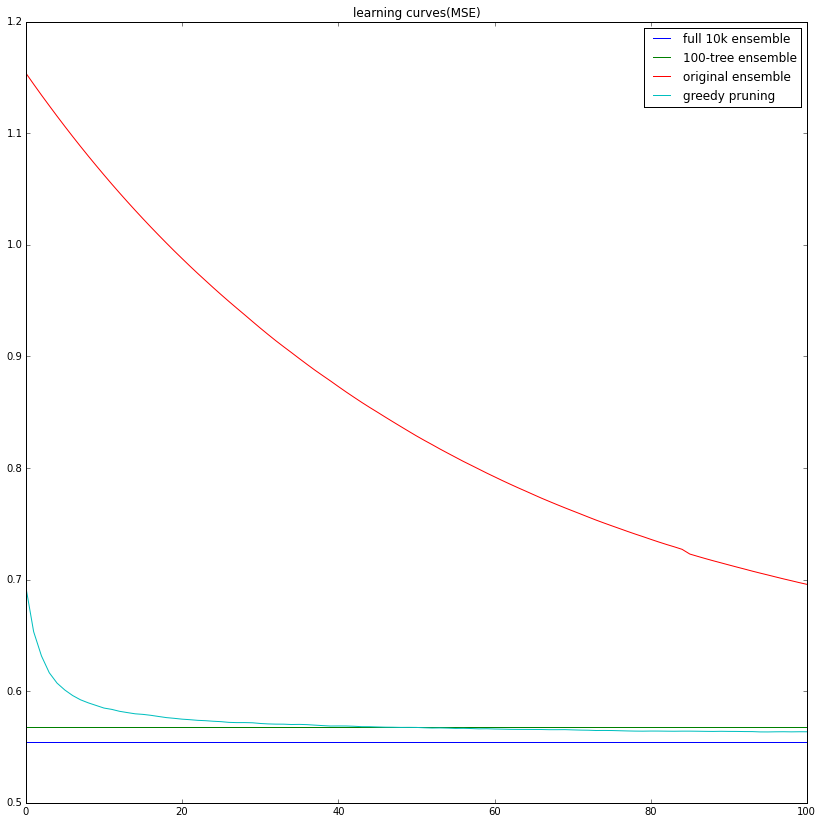

In [16]:
metric_name = 'MSE'
n_trees = target_n_trees
metric = metrics.mean_squared_error

stupid_lcurve = learning_curve(trees_stupid,testFactory,metric,n_trees)
greedy_lcurve = learning_curve(trees_greedy,testFactory,metric,n_trees)

full_line = metric(testFactory.labels,y_pred_full)

p = range(n_trees+1)

plt.figure(figsize = [14,14])
plt.plot(p,[full_line for i in p],label = "full 10k ensemble")
plt.plot(p,[0.568 for i in p],label = "100-tree ensemble")
plt.plot(p,stupid_lcurve,label = "original ensemble")
plt.plot(p,greedy_lcurve,label = "greedy pruning")
plt.title('learning curves('+metric_name+')')
plt.legend(loc="upper right")


#побольше-пожирнее
Отпрунена модель на 1к деревьев. Параметры не подбирал, Learning rate = 0.15 явный перебор, но всё равно качество неплохое. Хотя имхо пока оно проигрывает идеально подобранной по параметрам новой формуле, но это правится нормальным learning-rate-ом.

In [58]:
%%time
read = True
fname="../dumps/last_greedy_1k.pcl"
if not read:
    trees_greedy_1k = greedy.greed_up_features_bfs(trees,            #все деревья
                                    trainFactory,                 #данные
                                    loss = MSELoss,               #функция потерь
                                    learning_rate = .25,          #шаг обучения
                                    nTrees = 1000,#target_n_trees,      #итоговый размер формулы
                                    trees_sample_size =1000,       #размер подвыборки деревьев на каждой итерации
                                    verbose = False,              #логи
                                    regularizer=0.0005*len(trainFactory.labels), #Регуляризатор значения в листе(аддитивно к знаменателю)
                                    use_joblib=global_use_joblib, #использовать ли многопоточность
                                    n_jobs=global_n_jobs,         #Число потоков(joblib)
                                                )
    cDump(trees_greedy_1k,fname)
else:
    trees_greedy_1k = cLoad(fname)
    

CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 103 ms


In [59]:
!ls ../dumps/ |grep last_greedy_1k

last_greedy_1k.pcl
last_greedy_1k_lr.05.pcl
last_greedy_1k_lr.25.pcl


In [60]:
y_pred_greedy_1k = trees_greedy_1k.predict(testFactory)

##метрики

In [61]:
trees_stupid_1k = pf(trees[:1000],bias)
y_pred_stupid_1k = trees_stupid_1k.predict(testFactory)

In [62]:
print '100-greedy ',metrics.mean_squared_error(testFactory.labels,y_pred_greedy)
print '1k -greedy ',metrics.mean_squared_error(testFactory.labels,y_pred_greedy_1k)
print '1k original',metrics.mean_squared_error(testFactory.labels,y_pred_stupid_1k)
print '10k original',metrics.mean_squared_error(testFactory.labels,y_pred_full)
print "well..."

100-greedy  0.563639784007
1k -greedy  0.556495018611
1k original 0.57106185698
10k original 0.554568902063
well...


In [63]:
#NDCG
from ranking_metrics import mean_ndcg
for rank in [5,10,50,None]:
    print "\nNDCG@"+str(rank)
    print '100-greedy  :',mean_ndcg(testFactory.labels,y_pred_greedy,testFactory.ids,rank = rank)
    print '1k -greedy  :',mean_ndcg(testFactory.labels,y_pred_greedy_1k,testFactory.ids,rank = rank)
    print '1k original :',mean_ndcg(testFactory.labels,y_pred_stupid,testFactory.ids,rank = rank)
    print '10k original:',mean_ndcg(testFactory.labels,y_pred_full,testFactory.ids,rank = rank)


NDCG@5
100-greedy  : 0.523375561899
1k -greedy  : 0.534789116948
1k original : 0.449222985317
10k original: 0.537504303084

NDCG@10
100-greedy  : 0.529145210812
1k -greedy  : 0.540499836139
1k original : 0.456648840525
10k original: 0.543021161437

NDCG@50
100-greedy  : 0.606894830854
1k -greedy  : 0.616617041182
1k original : 0.55367057841
10k original: 0.618088956755

NDCG@None
100-greedy  : 0.751248862003
1k -greedy  : 0.756525750361
1k original : 0.721413686091
10k original: 0.757625718281


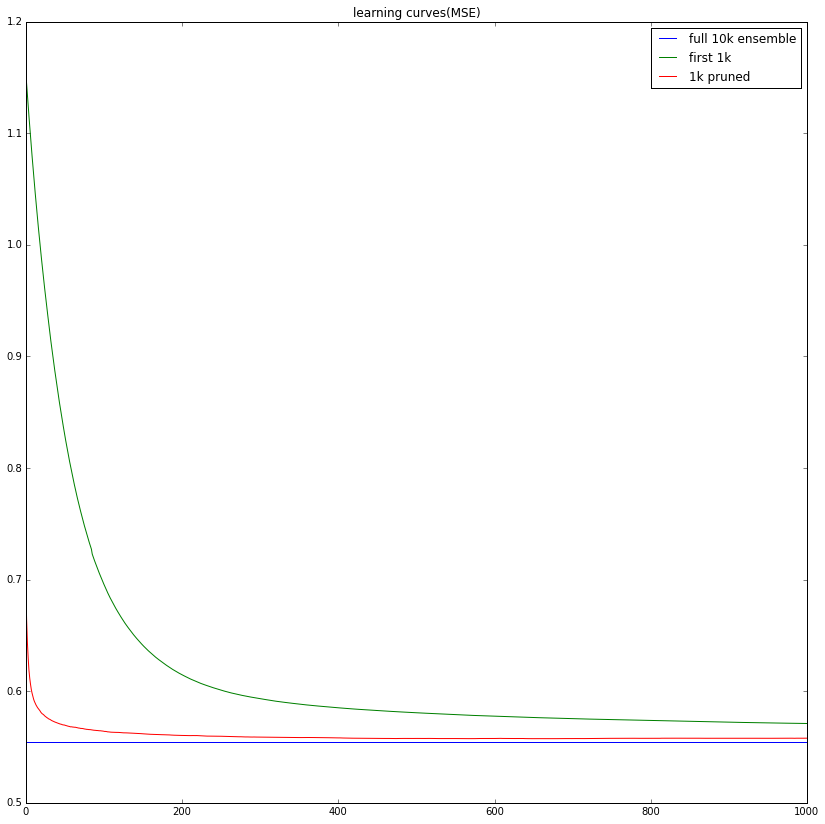

In [55]:
metric_name = 'MSE'
n_trees = 1000
metric = metrics.mean_squared_error

stupid_lcurve = learning_curve(trees_stupid_1k,testFactory,metric,n_trees)
greedy_lcurve = learning_curve(trees_greedy_1k,testFactory,metric,n_trees)

full_line = metric(testFactory.labels,y_pred_full)

p = range(n_trees+1)

plt.figure(figsize = [14,14])
plt.plot(p,[full_line for i in p],label = "full 10k ensemble")
plt.plot(p,stupid_lcurve,label = "first 1k")
plt.plot(p,greedy_lcurve,label = "1k pruned")
plt.title('learning curves('+metric_name+')')
plt.legend(loc="upper right")


#отбор напрямую по dcg пока не "зашёл".
Попытался сделать несколько различных извращений от отбора по NDCG до явного LAMBDAMART, все они не лучше (а  иногда хуже) MSE в пределах погрешности

In [23]:
from loss_functions import _MSEDCGLoss

In [24]:
MSEDCGLoss = _MSEDCGLoss(50)

In [25]:
%%time
read = True
fname="../dumps/dcg_greedy.pcl"
if not read:
    trees_greedy_dcg = greedy.greed_up_features_bfs(trees,            #все деревья
                                    trainFactory,                 #данные
                                    loss = MSEDCGLoss,               #функция потерь
                                    learning_rate = .35,          #шаг обучения
                                    nTrees = target_n_trees,      #итоговый размер формулы
                                    trees_sample_size =100,       #размер подвыборки деревьев на каждой итерации
                                    verbose = True,              #логи
                                    regularizer=0.0005*len(trainFactory.labels), #Регуляризатор значения в листе(аддитивно к знаменателю)
                                    use_joblib=global_use_joblib, #использовать ли многопоточность
                                    n_jobs=global_n_jobs,         #Число потоков(joblib)
                                                )
    cDump(trees_greedy_dcg,fname)
else:
    trees_greedy_dcg = cLoad(fname)

CPU times: user 14.4 ms, sys: 0 ns, total: 14.4 ms
Wall time: 16.2 ms


In [26]:
y_pred_dcg_greedy = trees_greedy_dcg.predict(testFactory)

In [27]:
print metrics.mean_squared_error(testFactory.labels,y_pred_greedy),
print metrics.mean_squared_error(testFactory.labels,y_pred_dcg_greedy),
print metrics.mean_squared_error(testFactory.labels,y_pred_stupid),
print metrics.mean_squared_error(testFactory.labels,y_pred_full)
print "well..."

0.563639784007 0.568333774093 0.695731252371 0.554568902063
well...


In [28]:
#NDCG
from ranking_metrics import mean_ndcg
for rank in [5,10,50,None]:
    print "\nNDCG@"+str(rank);
    print 'nTrees=',target_n_trees
    print 'greedy:',mean_ndcg(testFactory.labels,y_pred_greedy,testFactory.ids,rank = rank)
    print 'dcg:',mean_ndcg(testFactory.labels,y_pred_dcg_greedy,testFactory.ids,rank = rank)
    print 'stupid:',mean_ndcg(testFactory.labels,y_pred_stupid,testFactory.ids,rank = rank)
    print 'full:',mean_ndcg(testFactory.labels,y_pred_full,testFactory.ids,rank = rank)



NDCG@5
nTrees= 100
greedy: 0.523375561899
dcg: 0.523957769168
stupid: 0.449222985317
full: 0.537504303084

NDCG@10
nTrees= 100
greedy: 0.529145210812
dcg: 0.53250719763
stupid: 0.456648840525
full: 0.543021161437

NDCG@50
nTrees= 100
greedy: 0.606894830854
dcg: 0.606927163386
stupid: 0.55367057841
full: 0.618088956755

NDCG@None
nTrees= 100
greedy: 0.751248862003
dcg: 0.7581451923
stupid: 0.721413686091
full: 0.757625718281


#Раздельный прунинг
* Выборка делится на части таким образом, чтобы для разных частей были актуальны различные деревья
* Далее для каждой части обучается своя формула

##Разделение выборки
Для простоты имплементации, дерево верхнего уровня строится из наиболее популярных дихотомий изначальной формулы

In [29]:
#usability distribution
read = True
fname = '../dumps/thresholds.pcl'
if not read:
    thresholds = mnet.get_thresholds(trees,               #все деревья
                                     formula.feature_ids, #названия фич
                                     0.001                #tolerance к близким порогам дихотомий, 
                                                          #внутри которого дихотомии считаются одинаковыми 
                                                          #(доля дисперсии)
                                    )
    cDump(thresholds,fname)
else:    
    thresholds = cLoad(fname)

824


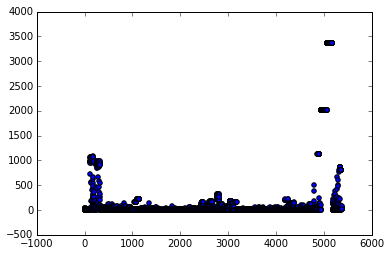

In [30]:
plt.scatter(range(len(thresholds)),thresholds[:,2])
print sum(thresholds[:,2] >100) #пороги хотя бы 100 раз встречаются в формуле

In [31]:
import alt_hierarchy as hierarchy # модуль, отвечающий за иерархический прунинг

In [32]:
%%time
read = True
fname = "../dumps/last_structure.pcl"
if not read:
    
    cand_thresholds = thresholds[thresholds[:,2]>=100]         #пороги хотя бы 100 раз встречаются в формуле

    root = hierarchy.create_hierarchy(trainFactory,            #данные (factory)
                                      trees,                   #все деревья
                                      cand_thresholds,         #пороги
                                      max_depth = 7,           #максимальная глубина
                                      event_sample = 0.1,      #доля примеров, по которым выбирается оптимальная
                                                               #дихотомия в каждом узле
                                      threshold_sample = 1.,   #доля порогов, рассматриваемых в качестве дихотомии
                                                               #в каждом узле
                                      min_events_split = 0.0,  #минимальная доля примеров в нелистовом узле
                                      min_events_leaf = 40000, #минимальная доля примеров в листовом узле
                                      
                                      metric = hierarchy.Penalized_entropy( #функция потерь
                                                                hierarchy.normalized_usability_entropy, 0.25),
                                      use_joblib = global_use_joblib,       #использовать ли параллелизм
                                      n_jobs = global_n_jobs               #число потоков/процессов
                                     ) 
    cDump(root,fname)
else:
    root = cLoad(fname)

CPU times: user 1.27 ms, sys: 46 µs, total: 1.31 ms
Wall time: 4.54 ms


##Вот-так выглядит дерево верхнего уровня

In [33]:
def printTree(root,t = '',code = "",wdict = None):
    if root.isLeaf:
        print t+'Leaf',
        if wdict is not None:
            print 'w:',wdict[code],
        print 'd:',len(t),'c:',code
    else:
        print t+'Split',len(t)
        for i in [0,1]:
            printTree(root.child[i],t+'\t',code+str(i),wdict = wdict)
def getLeafWeights(root,*args,**kwargs):
    sdict = root.split(trainFactory)
    wdict = {i:sdict[i].events.shape[0] for i in sdict}
    return wdict
wdict =getLeafWeights(root)
printTree(root,wdict = wdict)

Split 0
	Split 1
		Split 2
			Leaf w: 79149 d: 3 c: 000
			Split 3
				Leaf w: 43599 d: 4 c: 0010
				Leaf w: 40786 d: 4 c: 0011
		Split 2
			Leaf w: 61833 d: 3 c: 010
			Split 3
				Leaf w: 42084 d: 4 c: 0110
				Leaf w: 44107 d: 4 c: 0111
	Split 1
		Leaf w: 53186 d: 2 c: 10
		Split 2
			Split 3
				Leaf w: 62681 d: 4 c: 1100
				Split 4
					Leaf w: 73720 d: 5 c: 11010
					Leaf w: 42776 d: 5 c: 11011
			Split 3
				Split 4
					Leaf w: 40993 d: 5 c: 11100
					Leaf w: 58043 d: 5 c: 11101
				Split 4
					Leaf w: 40412 d: 5 c: 11110
					Leaf w: 40043 d: 5 c: 11111


##Прунинг для подвыборок
* Обычный жадный прунинг, аналогичный первой секции статьи, производится для каждого листа независимо.
* Для уменьшения переобучения, при прунинге в каждом листе в выборку добавляется часть примеров извне листа.

In [34]:
%%time
read = True
fname = "../dumps/last_splitted2.pcl"
if not read:
    
    trees_splitted = hierarchy.train_splitted_boosts(trees,                        #все деревья
                                                     trainFactory,                 #данные (factory)
                                                     root,                         #структура дерева
                                                     loss = MSELoss,               #функция потерь
                                                     learning_rate = 0.25,         #шаг обучения 
                                                     nTrees_leaf= target_n_trees,  #итоговое к-во деревьев в каждом листе
                                                     trees_sample_size=1000,        #подвыборка деревьев, рассматриваемая на каждой итерации
                                                     regularizer =0.0001*sum(trainFactory.weights), #регуляризатор значения в листе (аддитивно к знаменателю)
                                                     verbose=True,                 #логи
                                                     use_joblib =global_use_joblib,#использовать ли параллелизм
                                                     n_jobs = global_n_jobs,       #число потоков/процессов
                                                     inclusion_outside_leaf =0.9,  #размер подвыборки примеров извне листа,
                                                                                   #используемых при прунинге в нём (относительно листа)
                                                     weights_outside_leaf = 0.75,  #веса примеров извне листа, 
                                                                                   #используемые при прунинге в нём
                                                     ) 

    cDump(trees_splitted,fname)
else:
    trees_splitted = cLoad(fname)

CPU times: user 138 ms, sys: 80 µs, total: 138 ms
Wall time: 140 ms


In [35]:
y_pred_splitted= trees_splitted.predict(testFactory)

In [36]:
w_test = testFactory.weights
Yts = testFactory.labels
print 'spltd\t',metrics.mean_squared_error(Yts,y_pred_splitted)
print 'greedy\t',metrics.mean_squared_error(Yts,y_pred_greedy)
print 'stupid\t',metrics.mean_squared_error(Yts,y_pred_stupid)
print 'full\t',metrics.mean_squared_error(Yts,y_pred_full)
print "well..."

spltd	0.559991556357
greedy	0.563639784007
stupid	0.695731252371
full	0.554568902063
well...


In [40]:
#NDCG
from ranking_metrics import mean_ndcg
for rank in [5,10,50,None]:
    print "\nNDCG@"+str(rank);
    print 'nTrees=',target_n_trees
    print 'greedy:',mean_ndcg(testFactory.labels,y_pred_greedy,testFactory.ids,rank = rank)
    print 'splitted:',mean_ndcg(testFactory.labels,y_pred_splitted,testFactory.ids,rank = rank)
    print 'stupid:',mean_ndcg(testFactory.labels,y_pred_stupid,testFactory.ids,rank = rank)
    print 'full:',mean_ndcg(testFactory.labels,y_pred_full,testFactory.ids,rank = rank)



NDCG@5
nTrees= 100
greedy: 0.523375561899
splitted: 0.528789303636
stupid: 0.449222985317
full: 0.537504303084

NDCG@10
nTrees= 100
greedy: 0.529145210812
splitted: 0.533482659538
stupid: 0.456648840525
full: 0.543021161437

NDCG@50
nTrees= 100
greedy: 0.606894830854
splitted: 0.613047571786
stupid: 0.55367057841
full: 0.618088956755

NDCG@None
nTrees= 100
greedy: 0.751248862003
splitted: 0.755725595318
stupid: 0.721413686091
full: 0.757625718281


#Кривые обучения по MSE
Среднеквадратичная ошибка на тестовой выборке от количества деревьев

Формула EventFilter на 100 деревьев с правильным learning rate, имеющая MSE 0.568, лежит где-то у Лёши

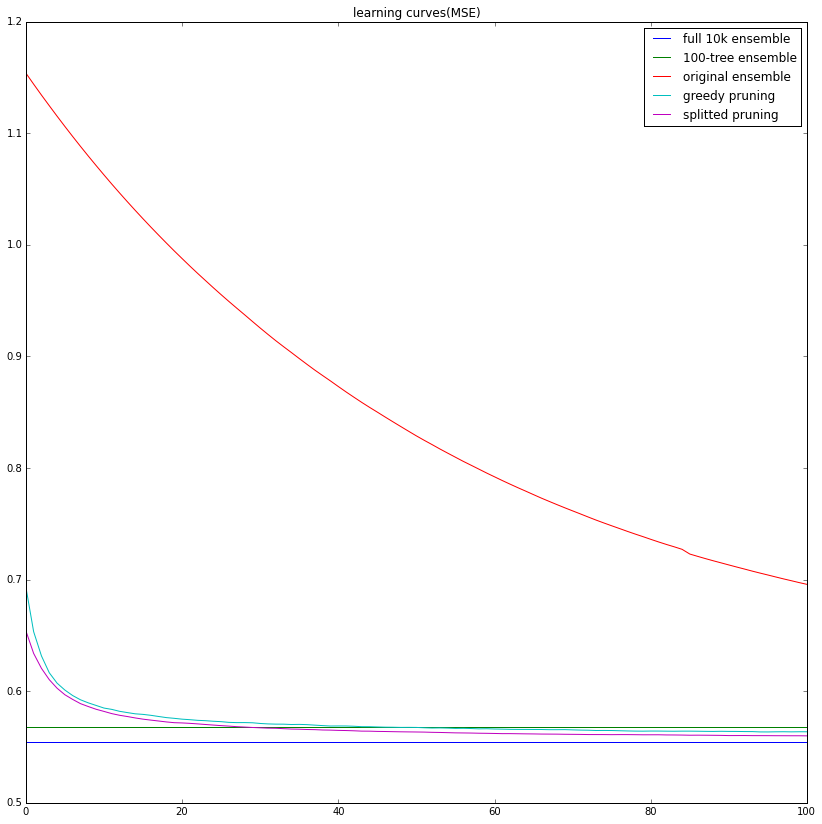

In [37]:
metric_name = 'MSE'
n_trees = target_n_trees
metric = metrics.mean_squared_error

stupid_lcurve = [i for i in learning_curve(trees_stupid,testFactory,metric,n_trees)]
greedy_lcurve = learning_curve(trees_greedy,testFactory,metric,n_trees)
splitted_lcurve = learning_curve(trees_splitted,testFactory,metric,n_trees)

full_line = metric(testFactory.labels,y_pred_full)

p = range(n_trees+1)

plt.figure(figsize = [14,14])
plt.plot(p,[full_line for i in p],label = "full 10k ensemble")
plt.plot(p,[0.568 for i in p],label = "100-tree ensemble")
plt.plot(p,stupid_lcurve,label = "original ensemble")
plt.plot(p,greedy_lcurve,label = "greedy pruning")
plt.plot(p,splitted_lcurve,label = "splitted pruning")
plt.title('learning curves('+metric_name+')')
plt.legend(loc="upper right")


In [38]:
def dcg_learning_curve(formula,factory,n_points = None,rank=50):
    
    lcurve = []

    Ypred = np.zeros(len(factory.labels))
                  
    for i,tree_pred in enumerate(formula.staged_predict(factory)):

        Ypred += tree_pred
        lcurve.append(mean_ndcg(factory.labels,Ypred,factory.ids,rank = rank) )
        if n_points is not None and i >= n_points:
            break
    while n_points is not None and i < n_points:
        i+=1
        lcurve.append(lcurve[-1])
        
    return lcurve

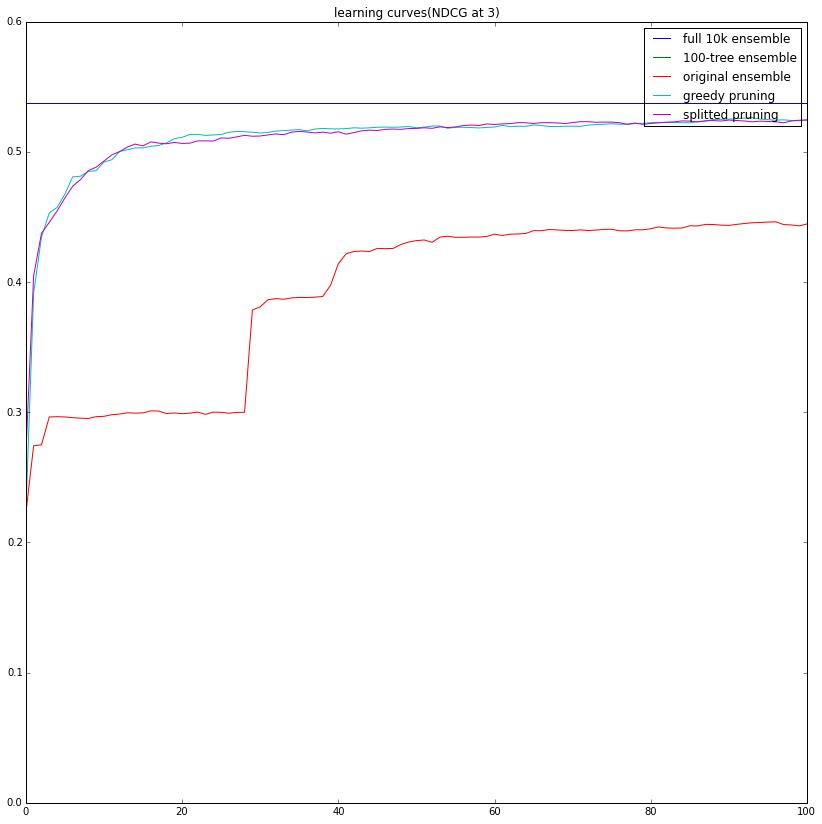

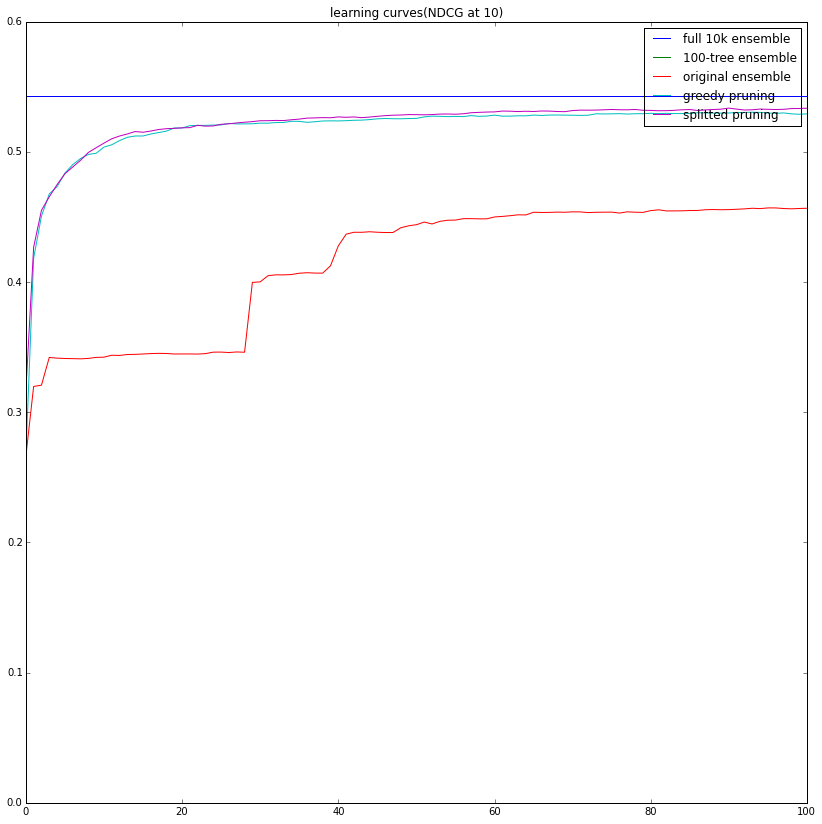

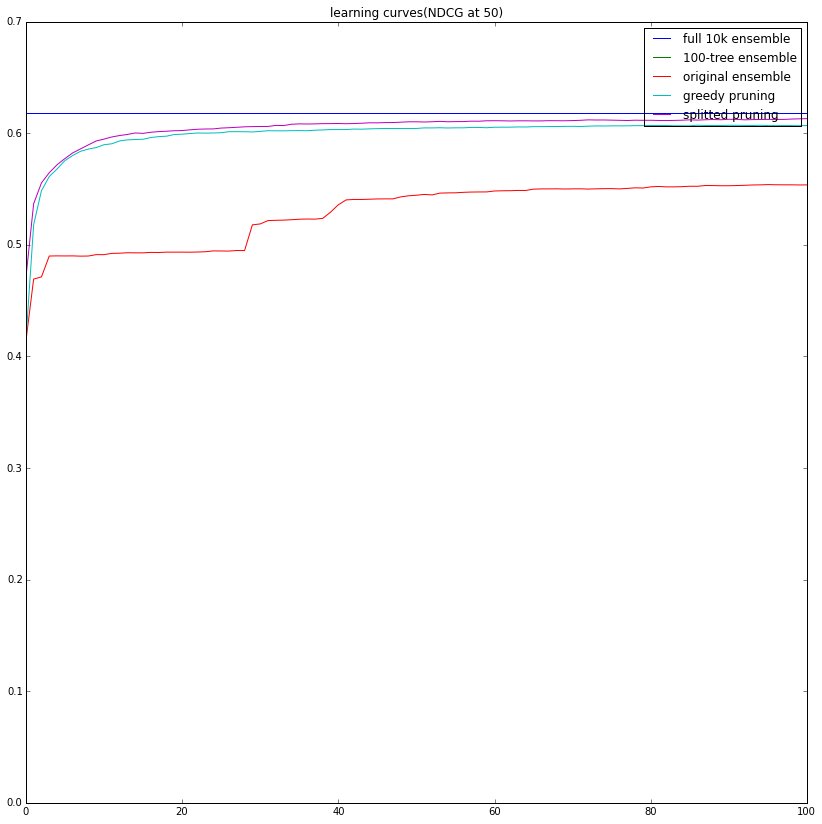

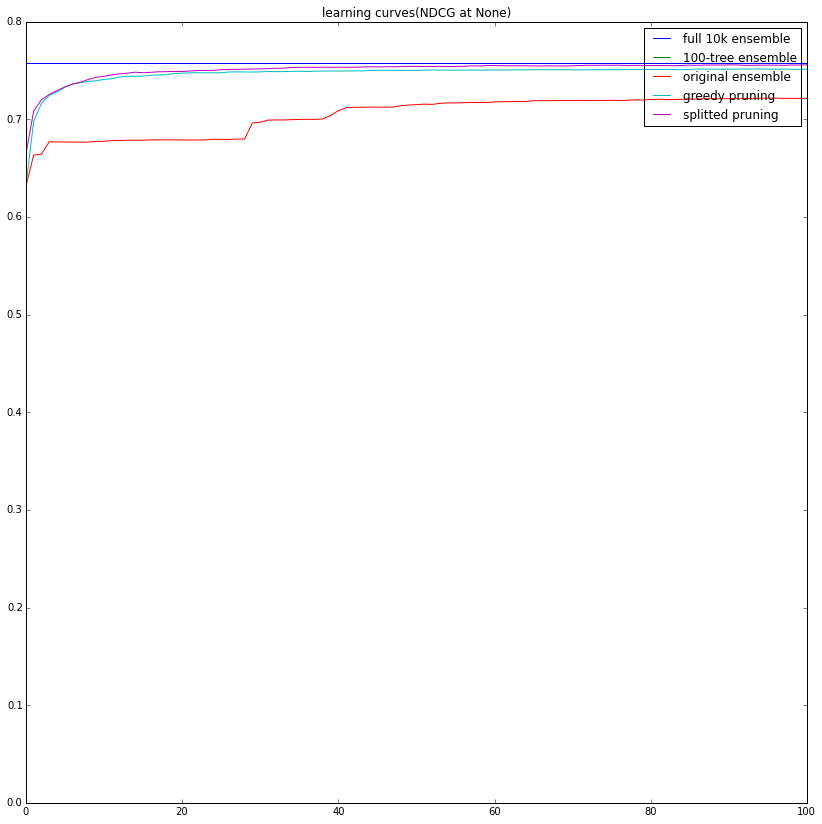

In [39]:
n_trees = target_n_trees
for rank in [3,10,50,None]:
    metric_name = 'NDCG at '+str(rank)
    n_trees = target_n_trees 
    stupid_lcurve = [i for i in dcg_learning_curve(trees_stupid,testFactory,n_trees,rank)]
    greedy_lcurve = dcg_learning_curve(trees_greedy,testFactory,n_trees,rank)
    splitted_lcurve = dcg_learning_curve(trees_splitted,testFactory,n_trees,rank)

    full_line = mean_ndcg(testFactory.labels,y_pred_full,testFactory.ids,rank=rank)

    
    p = range(n_trees+1)

    plt.figure(figsize = [14,14])
    plt.plot(p,[full_line for i in p],label = "full 10k ensemble")
    plt.plot(p,[0.0 for i in p],label = "100-tree ensemble")
    plt.plot(p,stupid_lcurve,label = "original ensemble")
    plt.plot(p,greedy_lcurve,label = "greedy pruning")
    plt.plot(p,splitted_lcurve,label = "splitted pruning")
    plt.title('learning curves('+metric_name+')')
    plt.legend(loc="upper right")
    plt.show()
